# Demand Prediction Project

Free or affordable access to bicycles for short trips in an urban area as an alternative to motorized public transportation or private vehicles is becoming more important by the day. As it is a means to reduce traffic congestion, noise and air pollution, supporting such heartwarming initiatives with a data science perspective is one of my biggest personal drives.

In this project, our goal is to predict the number of future bike shares using the historical data of London bike shares. Therefore, this case should be treated as a time series problem with ***Bidirectional LSTM***.

To achieve this goal, we will make predictions using LSTM. Unlike standard feed-forward neural networks, LSTM has feedback. It can process not only single data points, but also entire data series. 


---
---

# #Determines



#### Features

- timestamp - timestamp field for grouping the data
- cnt - the count of a new bike shares
- t1 - real temperature in C
- t2 - temperature in C “feels like”
- hum - humidity in percentage
- wind_speed - wind speed in km/h
- weather_code - category of the weather
- is_holiday - boolean field - 1 holiday / 0 non holiday
- is_weekend - boolean field - 1 if the day is weekend
- season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
-  "weather_code" category description: 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity, 2 = scattered clouds / few clouds , 3 = Broken clouds , 4 = Cloudy, 7 = Rain/ light Rain shower/ Light rain, 10 = rain with thunderstorm, 26 = snowfall, 94 = Freezing Fog

---

First, we will discover the data and recognize features, deal with missing values and outliers.

We will look at the data from different angles in different temporal splits. For example, we will visualize the distribution of bicycle shares by day of the week. With this graph, we can easily observe and draw conclusions about how people's behavior changes on a daily basis. Similarly, we can perform hourly, monthly, seasonal, etc. Perform analysis. In addition, we will analyze the correlation of variables with a heat map.


In the pre-processing task after train-test split and robust scaling, the challenge for us is to split the data into time steps and transform it into a three-dimensional Numpy array.


When making prediction, we will need to do the inverse transform process to get a true error score. Otherwise, the results we get with scaled target variables may mislead us.

Finally, we visualize how well our model's predictions match the actual values of the test data and also calculate error scores.

---
---

## 1. Exploratory Data Analysis

- Firstly, focus data based on the timestamp. You can create various variables such as, hour, day of week, day of month etc.
- You can check missing values and outliers.
- Also you can plot breakdowns of data.

### Importing Modules

In [1069]:
# Data and Stats packages
import numpy as np
import pandas as pd

import re
import string
from datetime import datetime as dt

# Visualization packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["axes.grid"] = False

import warnings
warnings.filterwarnings("ignore")

### Data Insights

In [1070]:
store = pd.read_csv('store_sharing.csv', index_col=0, parse_dates=True)

In [1071]:
store_raw = store.copy()

In [1072]:
store.shape

(17414, 9)

In [1073]:
store.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [1074]:
store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [1075]:
def first_look(df, col):
    val_c = pd.DataFrame(df[col].value_counts(dropna=False))
    val_c = val_c.assign(percent=(df[col].value_counts(dropna=False, normalize=True).values)*100)
    col_info = pd.DataFrame({'Column_Name': [col],'Null_Rows': [df[col].isna().sum()], 'Column_Type': [df[col].dtypes]}, index=['col_info'])
    return col_info, val_c

#### &emsp; i. timestamp

In [1076]:
col_info, val_c = first_look(store, store.columns[0])

In [1077]:
col_info

,Column_Name,Null_Rows,Column_Type
col_info,cnt,0,int64


In [1078]:
val_c

,cnt,percent
46,46,0.264155
53,39,0.223958
70,36,0.206730
33,36,0.206730
120,36,0.206730
...,...,...
3590,1,0.005743
1559,1,0.005743
3670,1,0.005743
3718,1,0.005743


As we are dealing with a timeseries problem we may obtain new columns out of the timestamp values.

In [1079]:
store['date_time'] = pd.to_datetime(store.index, format = '%Y-%m-%d %H:%M:%S')

In [1080]:
store.date_time

timestamp
2015-01-04 00:00:00   2015-01-04 00:00:00
2015-01-04 01:00:00   2015-01-04 01:00:00
2015-01-04 02:00:00   2015-01-04 02:00:00
2015-01-04 03:00:00   2015-01-04 03:00:00
2015-01-04 04:00:00   2015-01-04 04:00:00
                              ...        
2017-01-03 19:00:00   2017-01-03 19:00:00
2017-01-03 20:00:00   2017-01-03 20:00:00
2017-01-03 21:00:00   2017-01-03 21:00:00
2017-01-03 22:00:00   2017-01-03 22:00:00
2017-01-03 23:00:00   2017-01-03 23:00:00
Name: date_time, Length: 17414, dtype: datetime64[ns]

The date time is one of the critical features we have, and we need to do some feature engineering with this column to get the most out of our data and avoid possible multicollinearity.

In [1081]:
dt_df = pd.DataFrame(store.date_time)

In [1082]:
dt_df.head()

,date_time
timestamp,
2015-01-04 00:00:00,2015-01-04 00:00:00
2015-01-04 01:00:00,2015-01-04 01:00:00
2015-01-04 02:00:00,2015-01-04 02:00:00
2015-01-04 03:00:00,2015-01-04 03:00:00
2015-01-04 04:00:00,2015-01-04 04:00:00


In [1083]:
dt_df['date'] = dt_df.date_time.apply(lambda x: x.date())

In [1084]:
dt_df.date

timestamp
2015-01-04 00:00:00    2015-01-04
2015-01-04 01:00:00    2015-01-04
2015-01-04 02:00:00    2015-01-04
2015-01-04 03:00:00    2015-01-04
2015-01-04 04:00:00    2015-01-04
                          ...    
2017-01-03 19:00:00    2017-01-03
2017-01-03 20:00:00    2017-01-03
2017-01-03 21:00:00    2017-01-03
2017-01-03 22:00:00    2017-01-03
2017-01-03 23:00:00    2017-01-03
Name: date, Length: 17414, dtype: object

In [1085]:
dt_df['year'] = dt_df.date_time.apply(lambda x: x.year)

In [1086]:
dt_df.year.value_counts()

2016    8699
2015    8643
2017      72
Name: year, dtype: int64

In [1087]:
dt_df['month'] = dt_df.date_time.apply(lambda x: x.month)

In [1088]:
dt_df.month.value_counts()

5     1488
1     1487
12    1484
8     1484
7     1481
10    1479
3     1468
4     1438
11    1430
6     1422
9     1394
2     1359
Name: month, dtype: int64

In [1089]:
dt_df['week_day'] = dt_df.date_time.apply(lambda x: x.weekday())

In [1090]:
dt_df.week_day.value_counts()

0    2508
6    2505
1    2505
3    2492
2    2489
5    2465
4    2450
Name: week_day, dtype: int64

In [1091]:
dt_df['isweekend'] = dt_df.week_day.apply(lambda x: 0 if x in [5,6] else 1)

In [1092]:
dt_df.isweekend.value_counts()

1    12444
0     4970
Name: isweekend, dtype: int64

In [1093]:
dt_df['month_day'] = dt_df.date_time.apply(lambda x: x.day)

In [1094]:
dt_df.month_day.value_counts()

21    576
14    576
6     576
22    576
23    576
25    575
1     575
19    575
4     575
15    575
9     575
10    575
16    574
11    574
28    574
17    574
7     573
5     572
20    572
26    571
18    570
8     570
13    569
27    566
12    565
3     564
24    561
2     552
29    551
30    526
31    331
Name: month_day, dtype: int64

In [1095]:
dt_df['hour'] = dt_df.date_time.apply(lambda x: x.hour)

In [1096]:
dt_df.hour.value_counts()

16    730
15    729
12    729
14    728
13    728
17    728
18    728
11    727
9     727
19    727
20    727
21    726
6     726
7     726
22    725
10    725
8     724
1     724
0     724
23    722
5     721
4     721
3     721
2     721
Name: hour, dtype: int64

In [1097]:
dt_df.head()

,date_time,date,year,month,week_day,isweekend,month_day,hour
timestamp,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,2015-01-04,2015,1,6,0,4,0
2015-01-04 01:00:00,2015-01-04 01:00:00,2015-01-04,2015,1,6,0,4,1
2015-01-04 02:00:00,2015-01-04 02:00:00,2015-01-04,2015,1,6,0,4,2
2015-01-04 03:00:00,2015-01-04 03:00:00,2015-01-04,2015,1,6,0,4,3
2015-01-04 04:00:00,2015-01-04 04:00:00,2015-01-04,2015,1,6,0,4,4


#### &emsp; ii.  cnt - the count of a new bike shares

In [1098]:
inf, val = first_look(store, store.columns[1])

In [1099]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,t1,0,float64


In [1100]:
val

,t1,percent
13.000000,969,5.564488
12.000000,822,4.720340
9.000000,807,4.634202
14.000000,802,4.605490
11.000000,779,4.473412
...,...,...
31.000000,3,0.017228
31.500000,3,0.017228
34.000000,2,0.011485
10.333333,1,0.005743


<AxesSubplot:xlabel='cnt'>

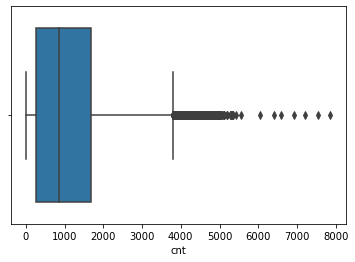

In [1101]:
sns.boxplot(store.cnt)

Since our goal is to make predictions regarding cnt, we need to take a closer look at cnt and its outliers. For now, we will leave this topic of outlier handling for the next session. 

#### &emsp; iii.  t1 - real temperature in C

In [1102]:
inf, val = first_look(store, store.columns[2])

In [1103]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,t2,0,float64


In [1104]:
val

,t2,percent
13.000000,969,5.564488
12.000000,821,4.714597
14.000000,802,4.605490
11.000000,774,4.444700
16.000000,729,4.186287
...,...,...
33.000000,2,0.011485
10.333333,1,0.005743
-5.500000,1,0.005743
-6.000000,1,0.005743


<AxesSubplot:xlabel='t1'>

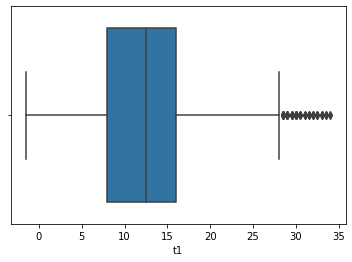

In [1105]:
sns.boxplot(store.t1)

Although C 30-35 appear to be "outliers" as they are outside Q3, as it can be observed in <a href="https://meteostat.net/en/place/GB-XCP5?t=2019-01-01/2019-12-31">temperature statistics for London</a>, these are acceptable and we will not consider them as outliers.

#### &emsp; iv.  t2 - temperature in C “feels like”

In [1106]:
inf, val = first_look(store, store.columns[3])

In [1107]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,hum,0,float64


In [1108]:
val

,hum,percent
88.0,965,5.541518
82.0,928,5.329046
77.0,774,4.444700
87.0,710,4.077179
76.0,513,2.945906
...,...,...
24.0,1,0.005743
23.0,1,0.005743
86.5,1,0.005743
26.5,1,0.005743


<AxesSubplot:xlabel='t2'>

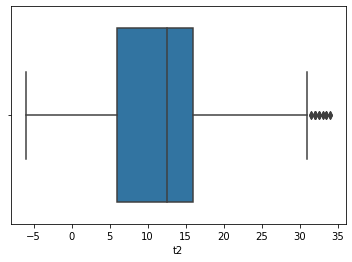

In [1109]:
sns.boxplot(store.t2)

As we mentioned before although 30-35 C  appear to be "outliers" as they are outside Q3, these are acceptable for London and we will not consider them as outliers. 
On the other hand t1 and t2 are usual suspects for multicollinearity. After a tedius assesment regarding correlation with cnt we will drop less correlated one. 
for now we leave this for the next step.

#### &emsp; v. hum - humidity in percentage

In [1110]:
inf, val = first_look(store, store.columns[4])

In [1111]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,wind_speed,0,float64


In [1112]:
val

,wind_speed,percent
12.000000,842,4.835190
11.000000,832,4.777765
14.000000,832,4.777765
15.000000,828,4.754795
13.000000,828,4.754795
...,...,...
36.500000,1,0.005743
47.500000,1,0.005743
13.500000,1,0.005743
2.666667,1,0.005743


<AxesSubplot:xlabel='hum'>

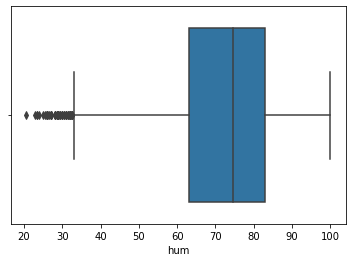

In [1113]:
sns.boxplot(store.hum)

Humidity below 30% in London is rare, but seems possible. We will address these "outliers" in the next session.

#### &emsp; vi. wind_speed - wind speed in km/h

In [1114]:
inf, val = first_look(store, store.columns[5])

In [1115]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,weather_code,0,float64


In [1116]:
val

,weather_code,percent
1.0,6150,35.316412
2.0,4034,23.165269
3.0,3551,20.391639
7.0,2141,12.294705
4.0,1464,8.407029
26.0,60,0.344550
10.0,14,0.080395


<AxesSubplot:xlabel='wind_speed'>

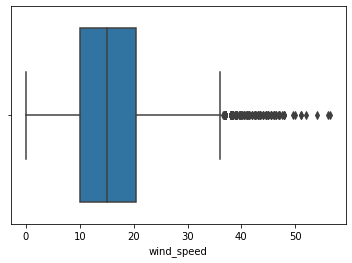

In [1117]:
sns.boxplot(store.wind_speed)

As it can be observed in <a href="https://meteostat.net/en/place/GB-XCP5?t=2019-01-01/2019-12-31">wind speed statistics for London</a> wind speed over 40 km is extremely rare. We will address these "outliers" in the next session.

#### &emsp; vii. weather_code - category of the weather

"weather_code" category description: 
- 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity
- 2 = scattered clouds / few clouds 
- 3 = Broken clouds 
- 4 = Cloudy
- 7 = Rain/ light Rain shower/ Light rain
- 10 = rain with thunderstorm
- 26 = snowfall
- 94 = Freezing Fog

In [1118]:
inf, val = first_look(store, store.columns[6])

In [1119]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,is_holiday,0,float64


In [1120]:
val

,is_holiday,percent
0.0,17030,97.794878
1.0,384,2.205122


The Wheather code is also a column where we had to apply feature engineering.

Let's chategorize whether as 'good' , 'mid', 'bad' where:
- good = 1 (Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity), 2 (scattered clouds / few clouds)
- mid = 3 (Broken clouds), 4 (Cloudy)
- bad = 7 (Rain/ light Rain shower/ Light rain), 10 (rain with thunderstorm), 26 (snowfall)

In [1121]:
store['weather_cathegory'] = store.weather_code.apply(lambda x: 'good' if x in [1,2] else ('mid' if x in [3, 4] else 'bad' ))

In [1122]:
store.weather_cathegory.value_counts()

good    10184
mid      5015
bad      2215
Name: weather_cathegory, dtype: int64

#### &emsp; viii. is_holiday - boolean field - 1 holiday / 0 non holiday

In [1123]:
inf, val = first_look(store, store.columns[7])

In [1124]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,is_weekend,0,float64


In [1125]:
val

,is_weekend,percent
0.0,12444,71.459745
1.0,4970,28.540255


Given the unbalanced distribution, we could combine this column and is_weekend to get a brand new feature instead of these two.

#### &emsp; ix. is_weekend - boolean field - 1 if the day is weekend

In [1126]:
inf, val = first_look(store, store.columns[8])

In [1127]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,season,0,float64


In [1128]:
val

,season,percent
0.0,4394,25.232571
1.0,4387,25.192374
3.0,4330,24.865051
2.0,4303,24.710003


In [1129]:
store['off_work'] = store.is_weekend + store.is_holiday
store['off_work'] = store.off_work.apply(lambda x: 0 if x==0 else 1)

In [1130]:
store.off_work.value_counts()

0    12060
1     5354
Name: off_work, dtype: int64

#### &emsp; x. season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

In [1131]:
inf, val = first_look(store, store.columns[9])

In [1132]:
inf

,Column_Name,Null_Rows,Column_Type
col_info,date_time,0,datetime64[ns]


In [1133]:
val

,date_time,percent
2015-09-21 23:00:00,1,0.005743
2016-04-10 23:00:00,1,0.005743
2015-05-27 13:00:00,1,0.005743
2016-09-27 15:00:00,1,0.005743
2016-03-30 22:00:00,1,0.005743
...,...,...
2016-01-24 19:00:00,1,0.005743
2015-10-29 19:00:00,1,0.005743
2016-12-06 15:00:00,1,0.005743
2015-12-05 05:00:00,1,0.005743


### Dealing With Outliers

<AxesSubplot:xlabel='cnt'>

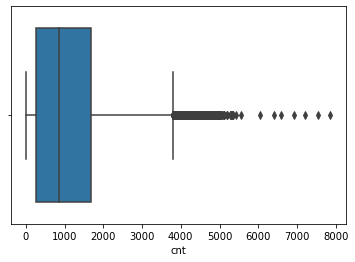

In [1134]:
sns.boxplot(x= 'cnt', data = store)

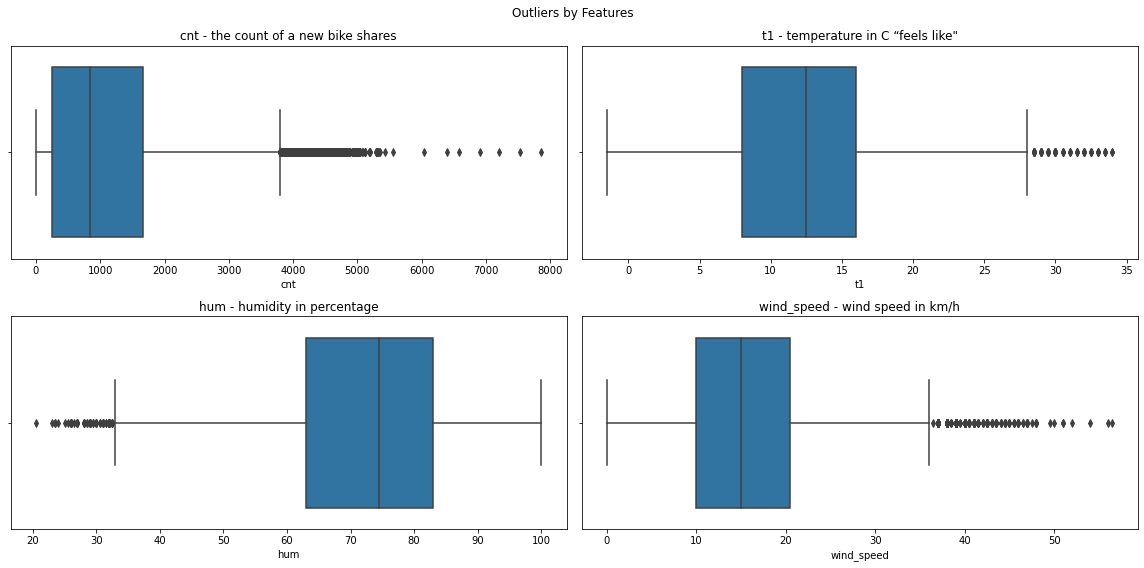

In [1135]:
fig, axes = plt.subplots(2,2, sharex=False, figsize=(16, 8))
fig.suptitle('Outliers by Features')

sns.boxplot(ax=axes[0,0], x= 'cnt', data = store)
axes[0,0].set_title('cnt - the count of a new bike shares')
sns.boxplot(ax=axes[0,1], x= 't1', data = store)
axes[0,1].set_title('t1 - temperature in C “feels like"')
sns.boxplot(ax=axes[1,0], x= 'hum', data = store)
axes[1,0].set_title('hum - humidity in percentage')
sns.boxplot(ax=axes[1,1], x= 'wind_speed', data = store)
axes[1,1].set_title('wind_speed - wind speed in km/h')
plt.tight_layout()
plt.show()

In [1136]:
store[store.cnt>5500].shape

(8, 12)

In [1137]:
store[store.cnt>4000].shape

(514, 12)

In [1138]:
store[(store.cnt.gt(4000)) & (store.weather_cathegory=='bad')]

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date_time,weather_cathegory,off_work
timestamp,,,,,,,,,,,,
2015-04-29 08:00:00,4069,10.0,7.0,71.0,22.0,7.0,0.0,0.0,0.0,2015-04-29 08:00:00,bad,0
2015-07-02 17:00:00,4193,24.5,24.5,61.0,18.5,7.0,0.0,0.0,1.0,2015-07-02 17:00:00,bad,0
2015-07-28 18:00:00,4200,19.0,19.0,49.0,25.5,7.0,0.0,0.0,1.0,2015-07-28 18:00:00,bad,0
2015-08-06 08:00:00,6585,19.0,19.0,78.0,12.0,7.0,0.0,0.0,1.0,2015-08-06 08:00:00,bad,0
2015-08-11 08:00:00,4384,16.5,16.5,66.0,6.0,7.0,0.0,0.0,1.0,2015-08-11 08:00:00,bad,0
2015-11-25 08:00:00,4170,9.0,5.5,76.0,26.0,7.0,0.0,0.0,2.0,2015-11-25 08:00:00,bad,0
2016-06-15 17:00:00,4208,18.5,18.5,60.0,17.5,7.0,0.0,0.0,1.0,2016-06-15 17:00:00,bad,0
2016-10-12 08:00:00,4541,11.0,11.0,88.0,11.0,7.0,0.0,0.0,2.0,2016-10-12 08:00:00,bad,0
2016-10-13 08:00:00,4196,10.0,8.0,88.0,12.0,7.0,0.0,0.0,2.0,2016-10-13 08:00:00,bad,0


In [1139]:
store[(store.cnt.gt(4000)) & (store.weather_cathegory=='bad') & (store.season == 3)]

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date_time,weather_cathegory,off_work
timestamp,,,,,,,,,,,,


In [1140]:
store.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date_time,weather_cathegory,off_work
timestamp,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015-01-04 00:00:00,mid,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015-01-04 01:00:00,good,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015-01-04 02:00:00,good,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015-01-04 03:00:00,good,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015-01-04 04:00:00,good,1


Since season is a comprehensive average of all climate characteristics, we will use it as a means for outlier handling.

In [1141]:
season_median = pd.DataFrame(store.groupby('season')['cnt'].median())
season_median

,cnt
season,
0.0,823
1.0,1214
2.0,898
3.0,632


In [1142]:
Q1 = store.cnt.quantile(0.25)
Q3 = store.cnt.quantile(0.75)
IQR = Q3 - Q1    

filter0 = ((store.cnt <= Q1 - 1.5 * IQR) | (store.cnt >= Q3 + 1.5 *IQR)) & (store.season == 0.0)
store['cnt'][filter0] = season_median.cnt.iloc[0]

filter1 = ((store.cnt <= Q1 - 1.5 * IQR) | (store.cnt >= Q3 + 1.5 *IQR)) & (store.season == 1.0)
store['cnt'][filter1] = season_median.cnt.iloc[1]

filter2 = ((store.cnt <= Q1 - 1.5 * IQR) | (store.cnt >= Q3 + 1.5 *IQR)) & (store.season == 2.0)
store['cnt'][filter2] = season_median.cnt.iloc[2]

filter3 = ((store.cnt <= Q1 - 1.5 * IQR) | (store.cnt >= Q3 + 1.5 *IQR)) & (store.season == 3.0)
store['cnt'][filter3] = season_median.cnt.iloc[3]

In [1143]:
season_median_t1 = pd.DataFrame(store.groupby('season')['t1'].median())

Q1 = store.t1.quantile(0.25)
Q3 = store.t1.quantile(0.75)
IQR = Q3 - Q1    

filter0 = ((store.t1 <= Q1 - 1.5 * IQR) | (store.t1 >= Q3 + 1.5 *IQR)) & (store.season == 0.0)
store['t1'][filter0] = season_median_t1.t1.iloc[0]

filter1 = ((store.t1 <= Q1 - 1.5 * IQR) | (store.t1 >= Q3 + 1.5 *IQR)) & (store.season == 1.0)
store['t1'][filter1] = season_median_t1.t1.iloc[1]

filter2 = ((store.t1 <= Q1 - 1.5 * IQR) | (store.t1 >= Q3 + 1.5 *IQR)) & (store.season == 2.0)
store['t1'][filter2] = season_median_t1.t1.iloc[2]

filter3 = ((store.t1 <= Q1 - 1.5 * IQR) | (store.t1 >= Q3 + 1.5 *IQR)) & (store.season == 3.0)
store['t1'][filter3] = season_median_t1.t1.iloc[3]

In [1144]:
season_median_hum = pd.DataFrame(store.groupby('season')['hum'].median())

Q1 = store.hum.quantile(0.25)
Q3 = store.hum.quantile(0.75)
IQR = Q3 - Q1    

filter0 = ((store.hum <= Q1 - 1.5 * IQR) | (store.hum >= Q3 + 1.5 *IQR)) & (store.season == 0.0)
store['hum'][filter0] = season_median_hum.hum.iloc[0]

filter1 = ((store.hum <= Q1 - 1.5 * IQR) | (store.hum >= Q3 + 1.5 *IQR)) & (store.season == 1.0)
store['hum'][filter1] = season_median_hum.hum.iloc[1]

filter2 = ((store.hum <= Q1 - 1.5 * IQR) | (store.hum >= Q3 + 1.5 *IQR)) & (store.season == 2.0)
store['hum'][filter2] = season_median_hum.hum.iloc[2]

filter3 = ((store.hum <= Q1 - 1.5 * IQR) | (store.hum >= Q3 + 1.5 *IQR)) & (store.season == 3.0)
store['hum'][filter3] = season_median_hum.hum.iloc[3]

In [1145]:
season_median_wind_speed = pd.DataFrame(store.groupby('season')['wind_speed'].median())

Q1 = store.wind_speed.quantile(0.25)
Q3 = store.wind_speed.quantile(0.75)
IQR = Q3 - Q1    

filter0 = ((store.wind_speed <= Q1 - 1.5 * IQR) | (store.wind_speed >= Q3 + 1.5 *IQR)) & (store.season == 0.0)
store['wind_speed'][filter0] = season_median_wind_speed.wind_speed.iloc[0]

filter1 = ((store.wind_speed <= Q1 - 1.5 * IQR) | (store.wind_speed >= Q3 + 1.5 *IQR)) & (store.season == 1.0)
store['wind_speed'][filter1] = season_median_wind_speed.wind_speed.iloc[1]

filter2 = ((store.wind_speed <= Q1 - 1.5 * IQR) | (store.wind_speed >= Q3 + 1.5 *IQR)) & (store.season == 2.0)
store['wind_speed'][filter2] = season_median_wind_speed.wind_speed.iloc[2]

filter3 = ((store.wind_speed <= Q1 - 1.5 * IQR) | (store.wind_speed >= Q3 + 1.5 *IQR)) & (store.season == 3.0)
store['wind_speed'][filter3] = season_median_wind_speed.wind_speed.iloc[3]

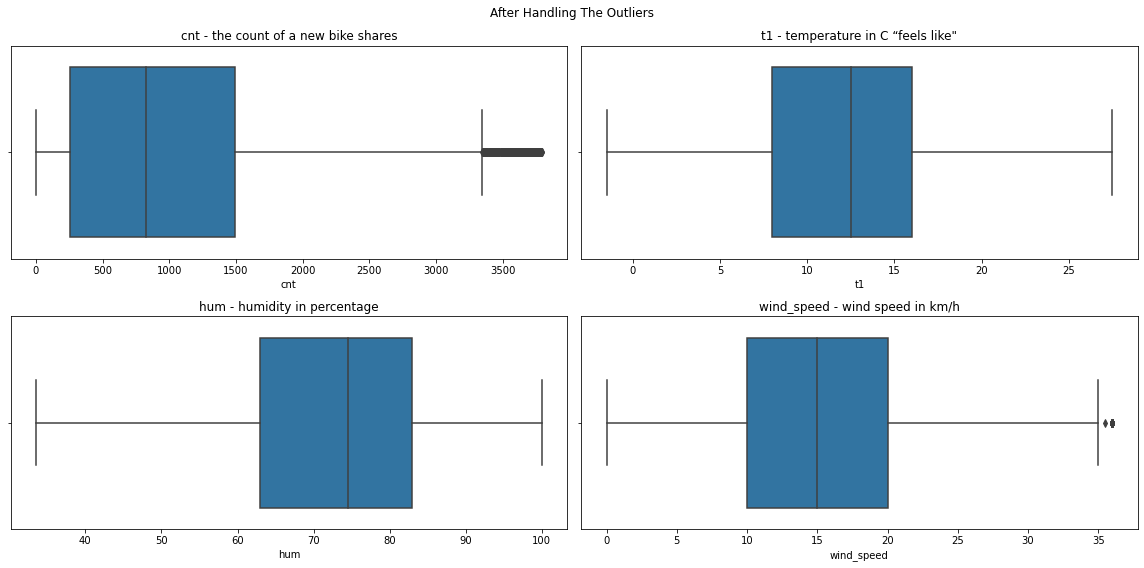

In [1146]:
fig, axes = plt.subplots(2,2, sharex=False, figsize=(16, 8))
fig.suptitle('After Handling The Outliers')

sns.boxplot(ax=axes[0,0], x= 'cnt', data = store)
axes[0,0].set_title('cnt - the count of a new bike shares')
sns.boxplot(ax=axes[0,1], x= 't1', data = store)
axes[0,1].set_title('t1 - temperature in C “feels like"')
sns.boxplot(ax=axes[1,0], x= 'hum', data = store)
axes[1,0].set_title('hum - humidity in percentage')
sns.boxplot(ax=axes[1,1], x= 'wind_speed', data = store)
axes[1,1].set_title('wind_speed - wind speed in km/h')
plt.tight_layout()
plt.show()

### Plot Breakdowns of Data

In [1147]:
store.corr()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,off_work
cnt,1.000000,0.367775,0.351408,-0.474779,0.153253,-0.148299,-0.042189,-0.042808,-0.108092,-0.055322
t1,0.367775,1.000000,0.979685,-0.422791,0.160605,-0.091606,-0.041557,-0.000696,-0.289564,-0.013907
t2,0.351408,0.979685,1.000000,-0.391493,0.098617,-0.098385,-0.040051,-0.008510,-0.285900,-0.021075
hum,-0.474779,-0.422791,-0.391493,1.000000,-0.293382,0.331985,0.030683,0.026387,0.285737,0.035589
wind_speed,0.153253,0.160605,0.098617,-0.293382,1.000000,0.107218,-0.014931,0.008825,0.003210,0.003885
weather_code,-0.148299,-0.091606,-0.098385,0.331985,0.107218,1.000000,0.012939,0.042362,0.098976,0.045577
is_holiday,-0.042189,-0.041557,-0.040051,0.030683,-0.014931,0.012939,1.000000,-0.094898,-0.032488,0.225368
is_weekend,-0.042808,-0.000696,-0.008510,0.026387,0.008825,0.042362,-0.094898,1.000000,0.001067,0.948490
season,-0.108092,-0.289564,-0.285900,0.285737,0.003210,0.098976,-0.032488,0.001067,1.000000,-0.009295
off_work,-0.055322,-0.013907,-0.021075,0.035589,0.003885,0.045577,0.225368,0.948490,-0.009295,1.000000


<AxesSubplot:>

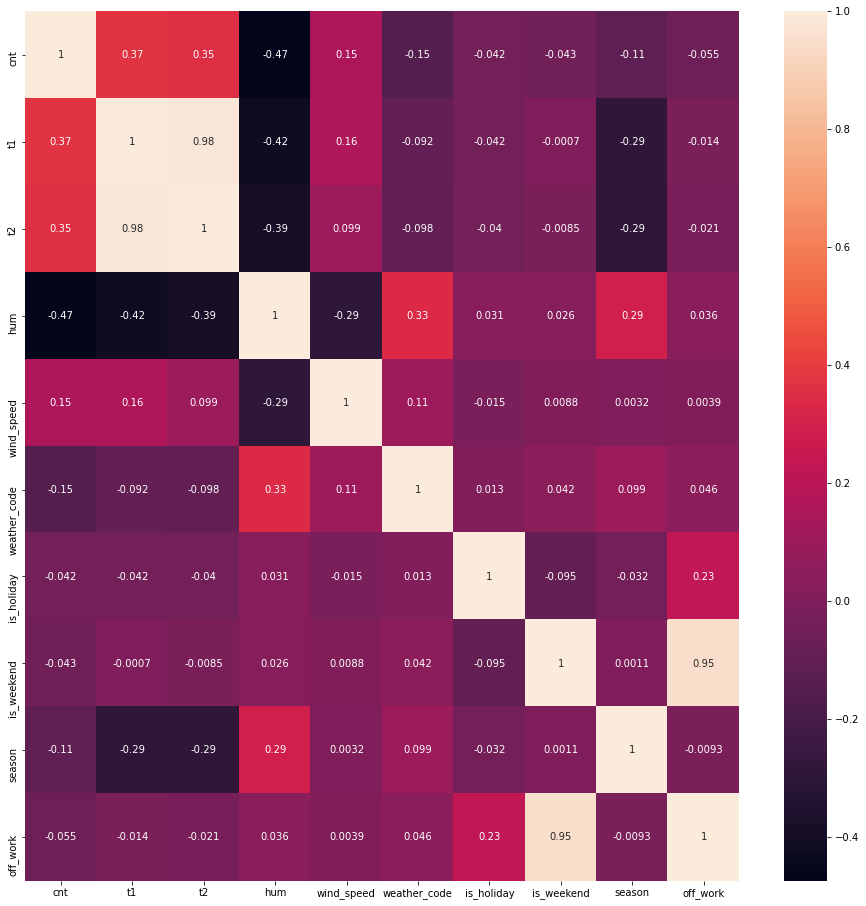

In [1148]:
plt.figure(figsize=(16,16))
sns.heatmap(store.corr(), annot=True)

Not to our surprise, 't1' and 't2' are extremely correlated and we are going to get rid of 't2'. On the other hand, we have created the 'off_work' column from the 'is_holiday' and 'is_weekend' columns, which means we will remove these two columns as well.
Before we drop these columns, let's visualize some breakthroughs in our data. To do this, we need to concatenate the columns we created from 'timestamp'. 

***i. Plot bike shares over time***

In [1155]:
dt_df.head(3)

,date_time,date,year,month,week_day,isweekend,month_day,hour
timestamp,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,2015-01-04,2015,1,6,0,4,0
2015-01-04 01:00:00,2015-01-04 01:00:00,2015-01-04,2015,1,6,0,4,1
2015-01-04 02:00:00,2015-01-04 02:00:00,2015-01-04,2015,1,6,0,4,2


In [1156]:
store.head(3)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date_time,weather_cathegory,off_work,months
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015-01-04 00:00:00,mid,1,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015-01-04 01:00:00,good,1,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015-01-04 02:00:00,good,1,1


In [1157]:
store['date_time'] = dt_df.date_time

<AxesSubplot:xlabel='date_time', ylabel='cnt'>

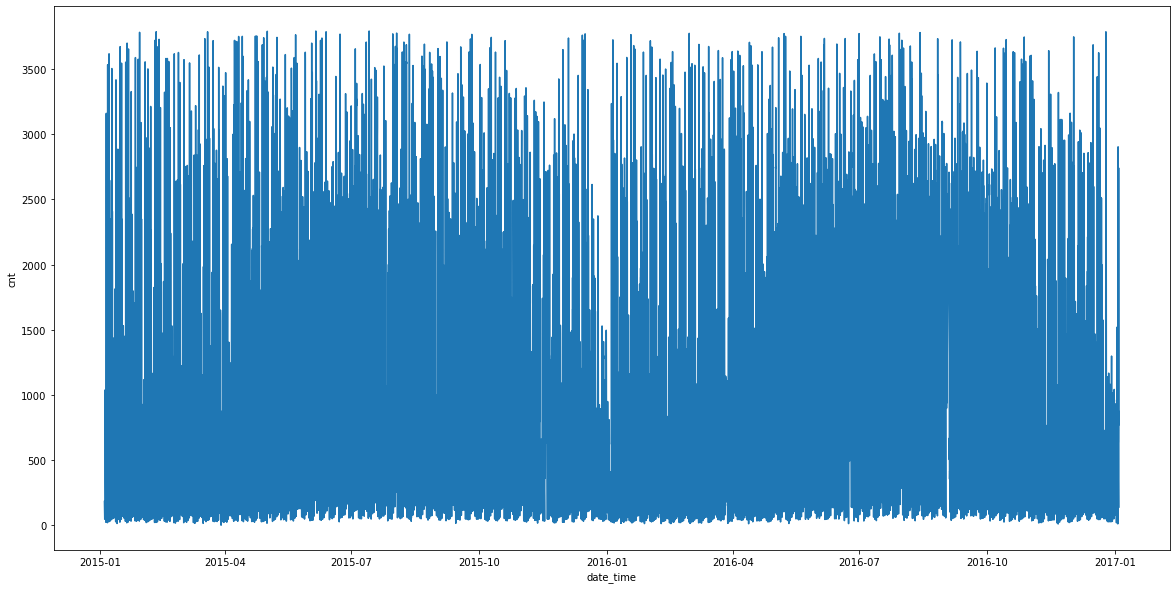

In [1158]:
plt.figure(figsize=(20,10))
sns.lineplot(x='date_time', y='cnt', data=store)

A seasonal pattern can be observed.

***ii. Plot bike shares by months***

In [1159]:
store['months'] = dt_df.month

<AxesSubplot:xlabel='months', ylabel='cnt'>

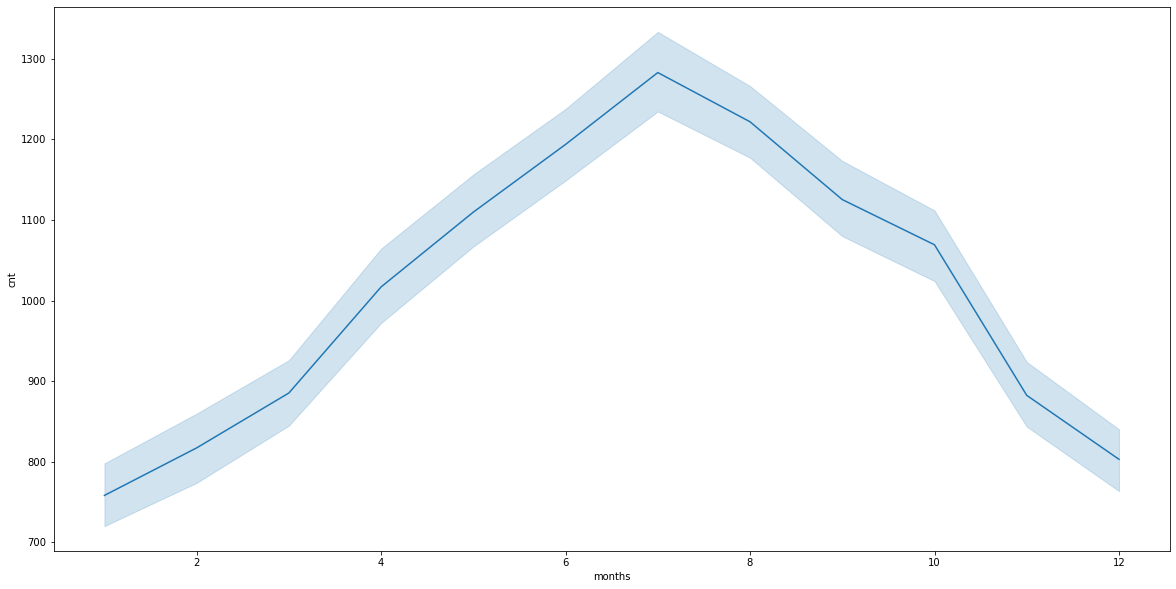

In [1160]:
plt.figure(figsize=(20,10))
sns.lineplot(x='months', y='cnt', data=store)

Beautiful sunny days and bikes nothing surprising right?

***iii. Plot bike shares by hours***
- *whether it is a holiday or not*

In [1161]:
store['hours'] = dt_df.hour

<AxesSubplot:xlabel='hours', ylabel='cnt'>

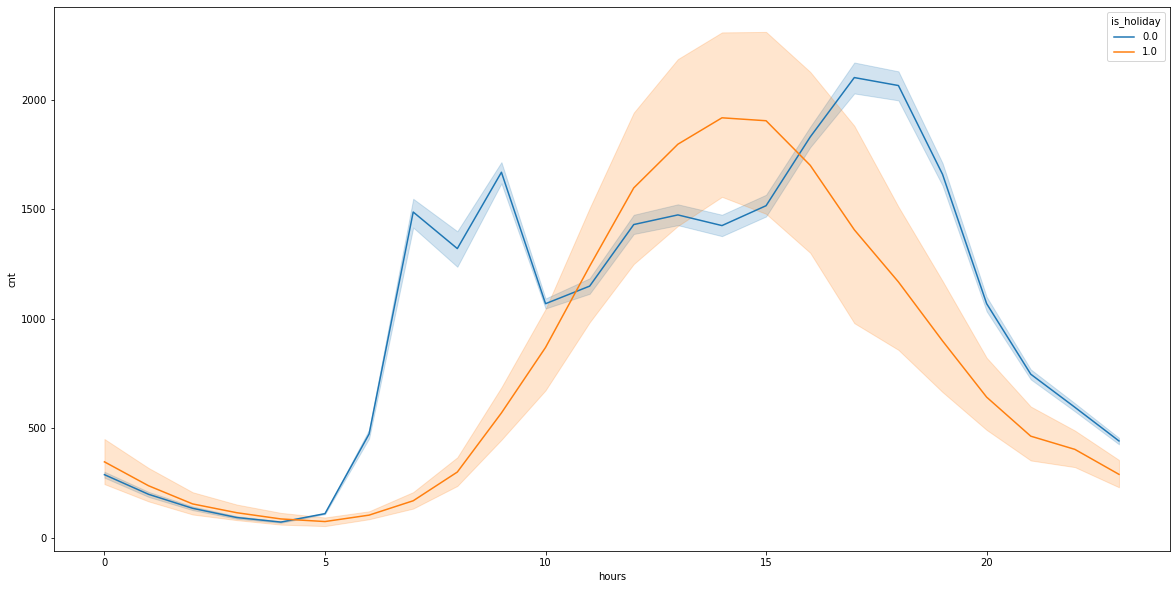

In [1162]:
plt.figure(figsize=(20,10))
sns.lineplot(x='hours', y='cnt', data=store, hue='is_holiday')

***iv. Plot bike shares by day of week***


In [1163]:
store['days'] = dt_df.week_day

<AxesSubplot:xlabel='days', ylabel='cnt'>

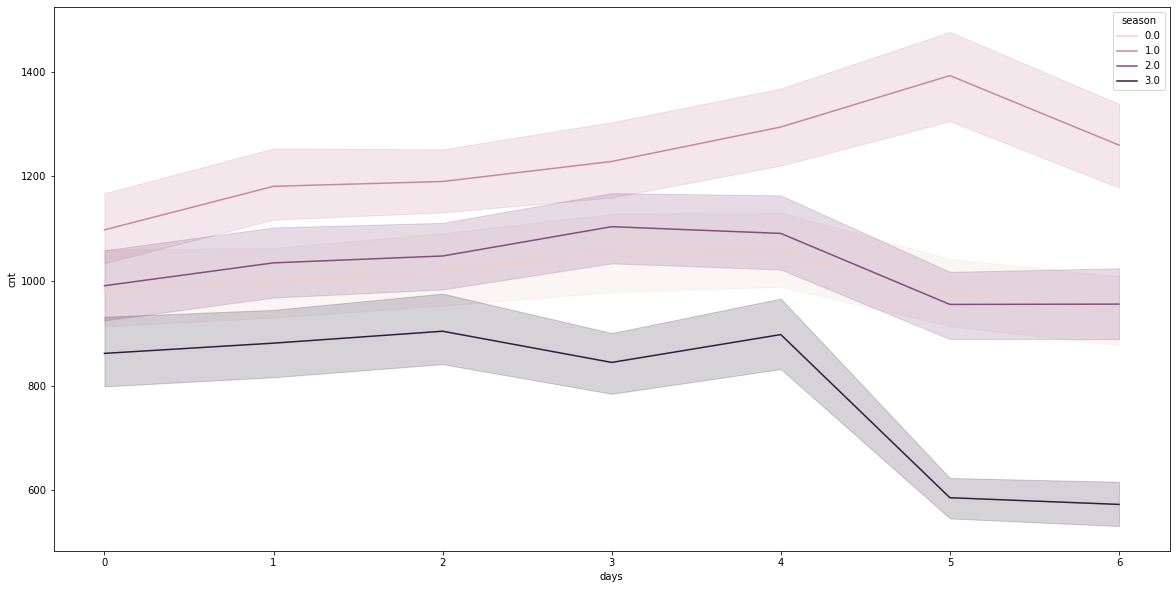

In [1164]:
plt.figure(figsize=(20,10))
sns.lineplot(x='days', y='cnt', data=store, hue='season')

Weekend bike share has an obvious seasinal distribution.

***v. Plot the distribution of bike shares on holidays by seasons***

<AxesSubplot:xlabel='is_holiday', ylabel='cnt'>

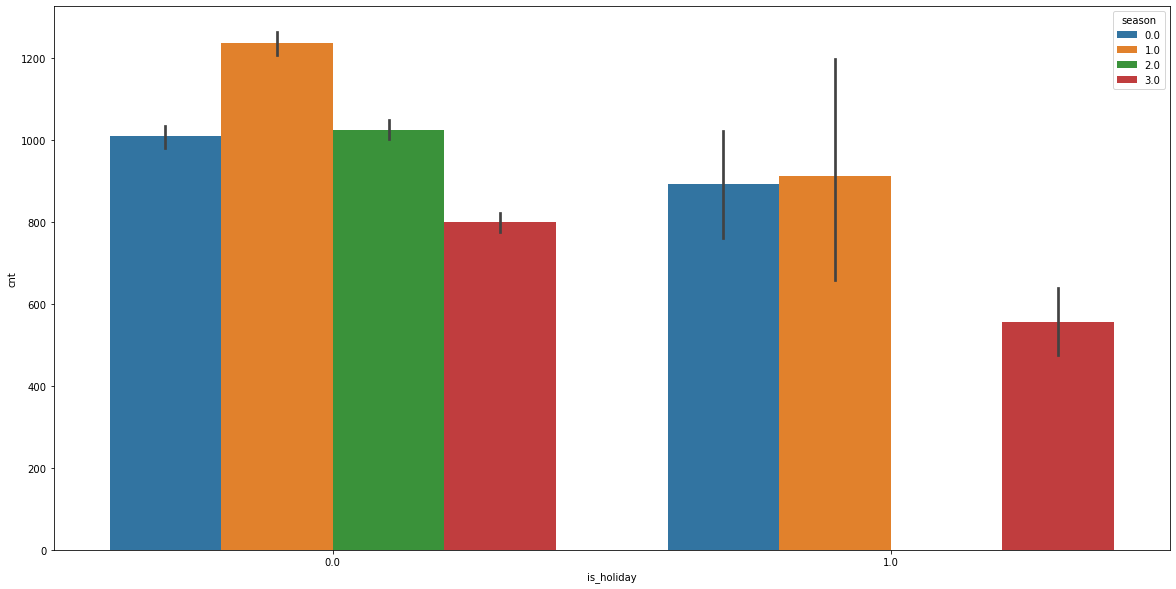

In [1166]:
plt.figure(figsize=(20,10))
sns.barplot(x='is_holiday', y='cnt', data=store, hue='season')

In [1167]:
store['month_days'] = dt_df.month_day

<AxesSubplot:xlabel='month_days', ylabel='cnt'>

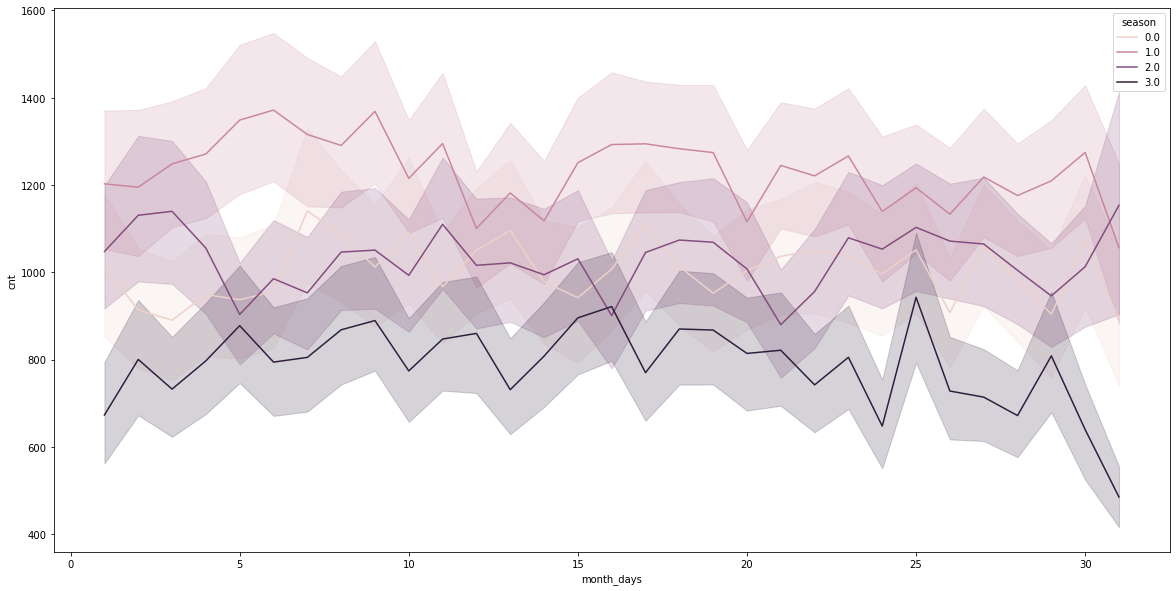

In [1168]:
plt.figure(figsize=(20,10))
sns.lineplot(x='month_days', y='cnt', data=store, hue='season')

We dont have a meaningful pattern here, we will drop this featur. Time to drop  columns that are not required anymore.

In [1169]:
store.columns

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season', 'date_time', 'weather_cathegory', 'off_work',
       'months', 'hours', 'days', 'month_days'],
      dtype='object')

In [488]:
store.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date_time,weather_cathegory,off_work,months,hours,days,month_days
timestamp,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015-01-04 00:00:00,mid,1,1,0,6,4
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015-01-04 01:00:00,good,1,1,1,6,4
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015-01-04 02:00:00,good,1,1,2,6,4
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015-01-04 03:00:00,good,1,1,3,6,4
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015-01-04 04:00:00,good,1,1,4,6,4


In [1170]:
bike = store.drop(columns=['t1', 'season', 'weather_code', 'off_work', 'date_time', 'month_days', 'months', 'hours', 'days'], axis=1)

In [1171]:
bike.head()

,cnt,t2,hum,wind_speed,is_holiday,is_weekend,weather_cathegory
timestamp,,,,,,,
2015-01-04 00:00:00,182,2.0,93.0,6.0,0.0,1.0,mid
2015-01-04 01:00:00,138,2.5,93.0,5.0,0.0,1.0,good
2015-01-04 02:00:00,134,2.5,96.5,0.0,0.0,1.0,good
2015-01-04 03:00:00,72,2.0,100.0,0.0,0.0,1.0,good
2015-01-04 04:00:00,47,0.0,93.0,6.5,0.0,1.0,good


In [1172]:
bike = pd.get_dummies(bike, columns=['weather_cathegory'], drop_first=True)

In [1173]:
bike.head()

,cnt,t2,hum,wind_speed,is_holiday,is_weekend,weather_cathegory_good,weather_cathegory_mid
timestamp,,,,,,,,
2015-01-04 00:00:00,182,2.0,93.0,6.0,0.0,1.0,0,1
2015-01-04 01:00:00,138,2.5,93.0,5.0,0.0,1.0,1,0
2015-01-04 02:00:00,134,2.5,96.5,0.0,0.0,1.0,1,0
2015-01-04 03:00:00,72,2.0,100.0,0.0,0.0,1.0,1,0
2015-01-04 04:00:00,47,0.0,93.0,6.5,0.0,1.0,1,0


Now we are ready to data pre-processing phase.

---
---

## 2. Data Pre-Processing


### Train - Test Split (Train-Dev)

We first need to split our original dataset into training and test datasets (quoting from Andrew NG of Stanford training and Development would be better suited terms however train-test is a wide terminology and we will follow that).Since the test data points represent real data. If we take the mean and variance of the entire data set, then we are introducing future information into the explanatory training variables. Therefore, **we should perform feature scaling over the training data and then perform normalization for the test instances as well,
but this time using the mean and standard deviation of the explanatory training variables.** In this way, we can test and evaluate whether our model generalizes well to new, unseen data points.
[Click here for more on scaling.](https://towardsdatascience.com/feature-scaling-and-normalisation-in-a-nutshell-5319af86f89b)

In [1174]:
from sklearn.model_selection import train_test_split

In [1175]:
bike.shape

(17414, 8)

In [1194]:
bike_train = bike.iloc[:(bike.shape[0]*85//100)]

In [1195]:
bike_test = bike.iloc[(bike.shape[0]*85//100):]

#### Scaling
The machine learning algorithm only sees numbers - if there is a big difference in range, for example, few in the thousands and few in the tens, and it makes the underlying assumption that numbers in the higher range are superior in some way. Thus, these more significant numbers begin to play a critical role in training the model.
Feature scaling is essential for machine learning algorithms that calculate distances between data. If not scaled, the feature with a higher range of values will begin to dominate in computing distances.
Some examples of algorithms where feature scaling matters are: K-nearest neighbors (KNN) with a Euclidean distance measure is sensitive to magnitudes and hence should be scaled for all features to weigh in equally. K-Means uses the Euclidean distance measure here feature scaling matters.
Scaling is critical while performing Principal Component Analysis(PCA). PCA tries to get the features with maximum variance, and the variance is high for high magnitude features and skews the PCA towards high magnitude features.
We can speed up gradient descent by scaling because θ (theta) descends quickly on small ranges and slowly on large ranges, and oscillates inefficiently down to the optimum when the variables are very uneven.

**Scaling Types:**

  - **Normalization**: Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1.

  - **Standardization**: Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

**Selecting Scaler:**

  - **Robust Scaler** : Robust to outliers. If our data contains many outliers, scaling using the mean and standard deviation of the data won’t work well. This Scaler removes the median and scales the data according to the quantile range. The centering and scaling statistics of this Scaler are based on percentiles and are therefore not influenced by a few numbers of huge marginal outliers.

  - **Min-Max Scaler** : This Scaler responds well if the standard deviation is small and when a distribution is not Gaussian. This Scaler is sensitive to outliers.
  
  - **Standard Scaler** : Assumes data is normally distributed within each feature and scales them such that the distribution centered around 0, with a standard deviation of 1.
  
  - **Max Abs Scaler** : Scale each feature by its maximum absolute value. This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set is 1.0. It does not shift/center the data and thus does not destroy any sparsity. On positive-only data, this Scaler behaves similarly to Min Max Scaler and, therefore, also suffers from the presence of significant outliers.

  - **Quantile Transformer Scaler** : Transform features using quantiles information. This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is, therefore, a robust pre-processing scheme. The cumulative distribution function of a feature is used to project the original values. Note that this transform is non-linear and may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable. This is also sometimes called as Rank scaler.
  
  - **Power Transformer Scaler** : The power transformer is a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to the variability of a variable that is unequal across the range (heteroscedasticity) or situations where normality is desired. The power transform finds the optimal scaling factor in stabilizing variance and minimizing skewness through maximum likelihood estimation. Currently, Sklearn implementation of PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood. Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data.

  - **Unit Vector Scaler** : Scaling is done considering the whole feature vector to be of unit length. This usually means dividing each component by the Euclidean length of the vector (L2 Norm). In some applications (e.g., histogram features), it can be more practical to use the L1 norm of the feature vector. Like Min-Max Scaling, the Unit Vector technique produces values of range [0,1]. When dealing with features with hard boundaries, this is quite useful. For example, when dealing with image data, the colors can range from only 0 to 255.


[Click here for more on scaling.](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

In [1196]:
from sklearn.preprocessing import RobustScaler

In [1197]:
X_columns = bike.drop(columns=['cnt'], axis=1).columns

In [1198]:
X_columns

Index(['t2', 'hum', 'wind_speed', 'is_holiday', 'is_weekend',
       'weather_cathegory_good', 'weather_cathegory_mid'],
      dtype='object')

In [1199]:
scaler = RobustScaler()
bike_train[X_columns] = scaler.fit_transform(bike_train[X_columns])
bike_test[X_columns] = scaler.transform(bike_test[X_columns])

In [1200]:
scalery = RobustScaler()
bike_train['cnt'] = scalery.fit_transform(bike_train[['cnt']])
bike_test['cnt'] = scalery.transform(bike_test[['cnt']])

In [1201]:
bike_train.head()

,cnt,t2,hum,wind_speed,is_holiday,is_weekend,weather_cathegory_good,weather_cathegory_mid
timestamp,,,,,,,,
2015-01-04 00:00:00,-0.509120,-1.000000,0.975,-0.952381,0.0,1.0,-1.0,1.0
2015-01-04 01:00:00,-0.544013,-0.954545,0.975,-1.047619,0.0,1.0,0.0,0.0
2015-01-04 02:00:00,-0.547185,-0.954545,1.150,-1.523810,0.0,1.0,0.0,0.0
2015-01-04 03:00:00,-0.596352,-1.000000,1.325,-1.523810,0.0,1.0,0.0,0.0
2015-01-04 04:00:00,-0.616178,-1.181818,0.975,-0.904762,0.0,1.0,0.0,0.0


### Creating Time Steps for LSTM

In [1202]:
import tensorflow as tf 

In [1203]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, Dropout

In [1204]:
def split_sequence(block, n_steps):
	X, y = list(), list()
	for i in range(len(block)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(block)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = block[i:end_ix], block.cnt[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [1205]:
X_train, y_train = split_sequence(bike_train, 10)

In [1206]:
X_test, y_test = split_sequence(bike_test, 10)

In [1207]:
print(X_train.shape, y_train.shape)

(14791, 10, 8) (14791,)


In [1208]:
model = Sequential()
model.add(Bidirectional(
    LSTM(
    units=128, 
    input_shape=(X_train.shape[1], X_train.shape[2]), activation ='relu'
    )
  )
)
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [1209]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
416/416 [==============================] - 19s 37ms/step - loss: 0.2616 - val_loss: 0.1835
Epoch 2/30
416/416 [==============================] - 15s 37ms/step - loss: 0.1847 - val_loss: 0.1738
Epoch 3/30
416/416 [==============================] - 15s 37ms/step - loss: 0.1376 - val_loss: 0.1643
Epoch 4/30
416/416 [==============================] - 16s 38ms/step - loss: 0.1027 - val_loss: 0.1523
Epoch 5/30
416/416 [==============================] - 15s 35ms/step - loss: 0.0904 - val_loss: 0.1393
Epoch 6/30
416/416 [==============================] - 14s 34ms/step - loss: 0.0875 - val_loss: 0.1673
Epoch 7/30
284/416 [===================>..........] - ETA: 5s - loss: 0.0700

KeyboardInterrupt: 

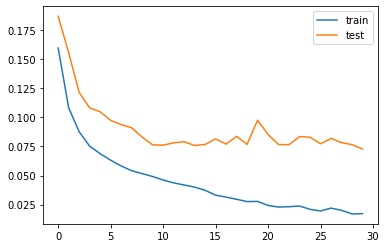

In [1066]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [549]:
y_pred = model.predict(X_test)

In [561]:
df = pd.DataFrame(y_pred)
df1 = pd.DataFrame(y_test)

In [565]:
df1

,0,1,2,3,4,5,6,7,8,9
0,66,1749,172,2866,1550,1479,146,44,1010,632
1,1749,172,2866,1550,1479,146,44,1010,632,571
2,172,2866,1550,1479,146,44,1010,632,571,898
3,2866,1550,1479,146,44,1010,632,571,898,2005
4,1550,1479,146,44,1010,632,571,898,2005,454
...,...,...,...,...,...,...,...,...,...,...
5210,571,2785,720,1684,178,325,233,299,117,2192
5211,2785,720,1684,178,325,233,299,117,2192,3002
5212,720,1684,178,325,233,299,117,2192,3002,1613
5213,1684,178,325,233,299,117,2192,3002,1613,1186


In [553]:
y_test.reshape(1, -1)

array([[  66, 1749,  172, ..., 1613, 1186, 1133]])

---
---

## 3. Model Building with LSTM



##Recurrent Neural Networks 
RNN are a type of artifcial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, the spoken word, numerical times series data.

Recurrent Neural Networks use backpropagation algorithm for training. Because of their internal memory, RNN’s are able to remember important things about the input they received, which enables them to be very precise in predicting what’s coming next.

RNNs could be stacked up to deeper versions, which contain more than 1 layers of RNN. Because RNNs are especially computationally expensive to train, normally a deep RNN model contains no more than 3 layers of LSTM.

Train a bidirectional long short term memory (LSTM) recurrent neural network (RNN) with this data, making use of the self-loop and forget gate of LSTM.

LSTM sequential learning model was chosen because of its ability to process sequential data and memorize data of past time steps.

LSTM is a different type of gated RNN which is capable of learning long-term dependencies LSTM is not affected by vanishing gradient or exploding gradient problem
Using Bidirectional LSTMs, we feed the learning algorithm with the original data once from beginning to the end and once from end to beginning.

#### Bidirectional LSTM :
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem. Figure shows the mechanism of Bidirectional LSTM.






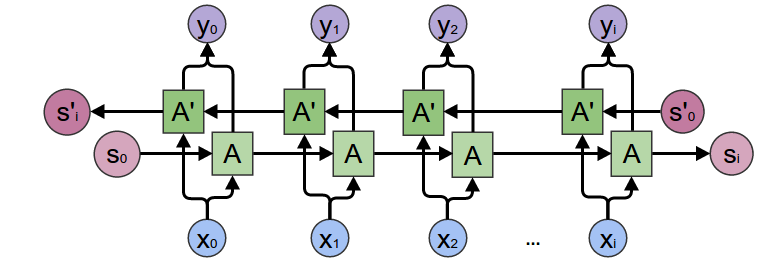

### Create, Compile and Fit Bidirectional LSTM Model

- Create a Sequential Model,
- Add Bidirectional layers,
- Apply Regularization (Drop Out),
- Compile the model.

***Note:*** *Define the optimizer as the efficient stochastic gradient descent algorithm ***adam***.* *This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.*

*In this case, use ***mean squared error*** as the loss argument. This loss is for a regression problems and is defined in Keras as mean_squared_error.
Also use defined in Keras as ***accuracy*** as the metrics.*

### Plot Train and Validation Losses

---
---

## 4. Demand Predictions

At this stage, you will measure the prediction success of your model. So, you will need to compare the actual values of the test data with their predicted values. 

For this reason, you must inverse transform the y_pred variable predicted by the model with the target variables of the train and test data you have previously scaled.

### Inverse Transform

### Plot Prediction

### Calculate Train and Test Error Scores